In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, r2_score

# Prepping data

In [41]:
elements = pd.read_csv('unique_m.csv')
reduced_ele = elements.loc[:, (elements != 0).any(axis=0)] # select columns containing non-zero elements
reduced_ele = reduced_ele.drop('material', axis = 1)
reduced_ele.head()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [5]:
temp = reduced_ele['critical_temp']
df_feature = reduced_ele.drop('critical_temp', axis = 1)
variables = df_feature.columns

## Train-test split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_feature, temp, test_size=0.2, random_state=42)

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_feats = X_train.shape[1]

print('number of observations in training set:', n_train)
print('number of observations in test set:', n_test)
print('number of features:', n_feats)

number of observations in training set: 17010
number of observations in test set: 4253
number of features: 77


## Standarize data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Default XGBoost

In [16]:
from xgboost import XGBRegressor

xg_model = XGBRegressor(random_state = 1)
xg_model.fit(X_train, y_train)
print("MSE Train:", mean_squared_error(y_train, xg_model.predict(X_train)))
print("MSE Train:", r2_score(y_train, xg_model.predict(X_train)))

MSE Train: 65.76804661823651
MSE Train: 0.944207650020328


In [33]:
xg_cv = XGBRegressor(random_state = 1)
cross_scores = cross_val_score(xg_cv, X_train, y_train, cv = KFold(shuffle = True, random_state = 1), scoring = 'neg_mean_squared_error', n_jobs = -1)
print(cross_scores)
print(cross_scores.mean())

[-105.01707222 -106.64544889 -114.12616722 -107.46295422 -100.23972986]
-106.69827448219465


## Testing Default XGBoost

In [37]:
pred = xg_model.predict(X_test)

In [21]:
print("MSE Test:", mean_squared_error(y_test, pred))
print("MSE Test:", r2_score(y_test, pred))

MSE Test: 94.74510125183784
MSE Test: 0.9176902874786395


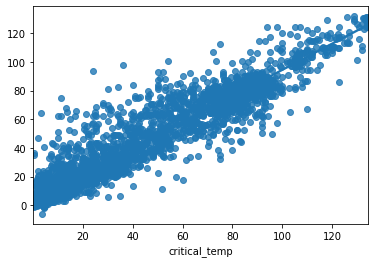

In [24]:
sns.regplot(x = y_test, y = pred)
plt.show()

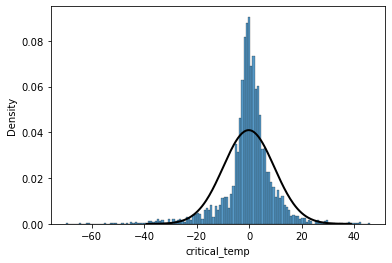

In [25]:
residual = y_test - pred
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

data = residual  
ax = sns.histplot(x=data, stat="density")
normal(data.mean(), data.std()) # a matter of choice: whether I want most being 0 and have large errors on outliers, or if I want to take into account of the outliers

### Checking performance on high temperatures

In [28]:
df_y= y_test.to_frame()
df_y['xgb'] = pred
df_y_g = df_y.loc[df_y['critical_temp'] > 77] # use liquid nitrogen as benchmark
df_y_s = df_y.loc[df_y['critical_temp'] <= 77]
#val_y_pred_0 = val_y_pred.loc[val_y_pred['critical_temp'] <= 4]
print(len(df_y_g))
print(len(df_y_s))
print("XGBoost MSE in higher than 77 critical temp", mean_squared_error(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost MSE in lower than 77 critical temp", mean_squared_error(df_y_s['xgb'], df_y_s['critical_temp']))
print("XGBoost R2 in higher than 77 critical temp", r2_score(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost R2 in lower than 77 critical temp", r2_score(df_y_s['xgb'], df_y_s['critical_temp']))

761
3492
XGBoost MSE in higher than 77 critical temp 129.0243077255402
XGBoost MSE in lower than 77 critical temp 87.27474726372571
XGBoost R2 in higher than 77 critical temp 0.42892037461398824
XGBoost R2 in lower than 77 critical temp 0.8302176541672568


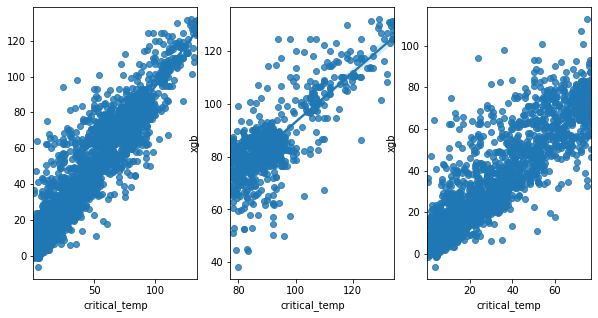

In [30]:
fig, axes = plt.subplots(1,3, figsize = (10,5))
ax1 = axes[0]
sns.regplot(ax = ax1, x = y_test, y = pred)
ax2 = axes[1]
sns.regplot(ax = ax2, x = df_y_g['critical_temp'], y = df_y_g['xgb'])
ax3 = axes[2]
sns.regplot(ax = ax3, x = df_y_s['critical_temp'], y = df_y_s['xgb'])
plt.show()